<a href="https://colab.research.google.com/github/ancestor9/2025_Spring_Data-Management/blob/main/week_14/A_Short_Guide_for_Feature_Engineering_and_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

print("Feature Engineering and Selection Examples")
print("=" * 100)

Feature Engineering and Selection Examples


In [ ]:
# ===============================================================
# 1. Data Exploration
# ===============================================================


1. DATA EXPLORATION
----------------------------------------
Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569

1.1 Variable Identification
------------------------------
Feature types:
float64    30
Name: count, dtype: int64

1.2 Univariate Analysis
------------------------------
Basic statistics for first 5 features:
       mean radius  mean texture  mean perimeter    mean area  mean smoothness
count   569.000000    569.000000      569.000000   569.000000       569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360
std       3.524049      4.301036       24.298981   351.914129         0.014064
min       6.981000      9.710000       43.790000   143.500000         0.052630
25%      11.700000     16.170000       75.170000   420.300000         0.086370
50%      13.370000     18.840000       86.240000   551.100000         0.095870
75%      15.780000     21.800000      104.100000   782.700000         0.105300
max      28.110000     39

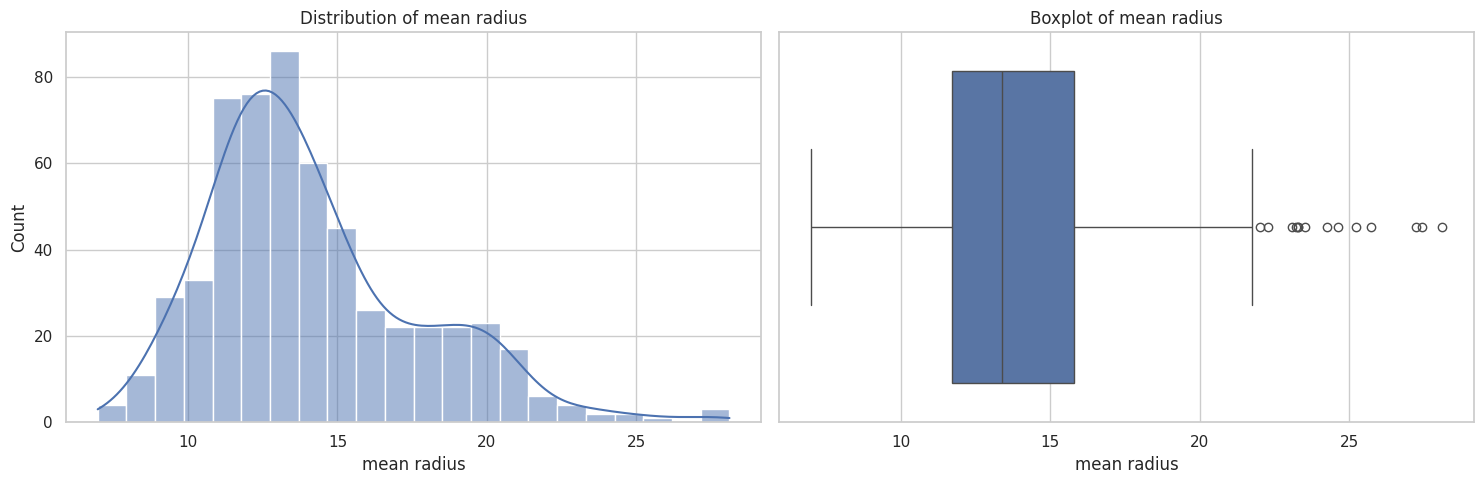


1.3 Bi-variate Analysis
------------------------------


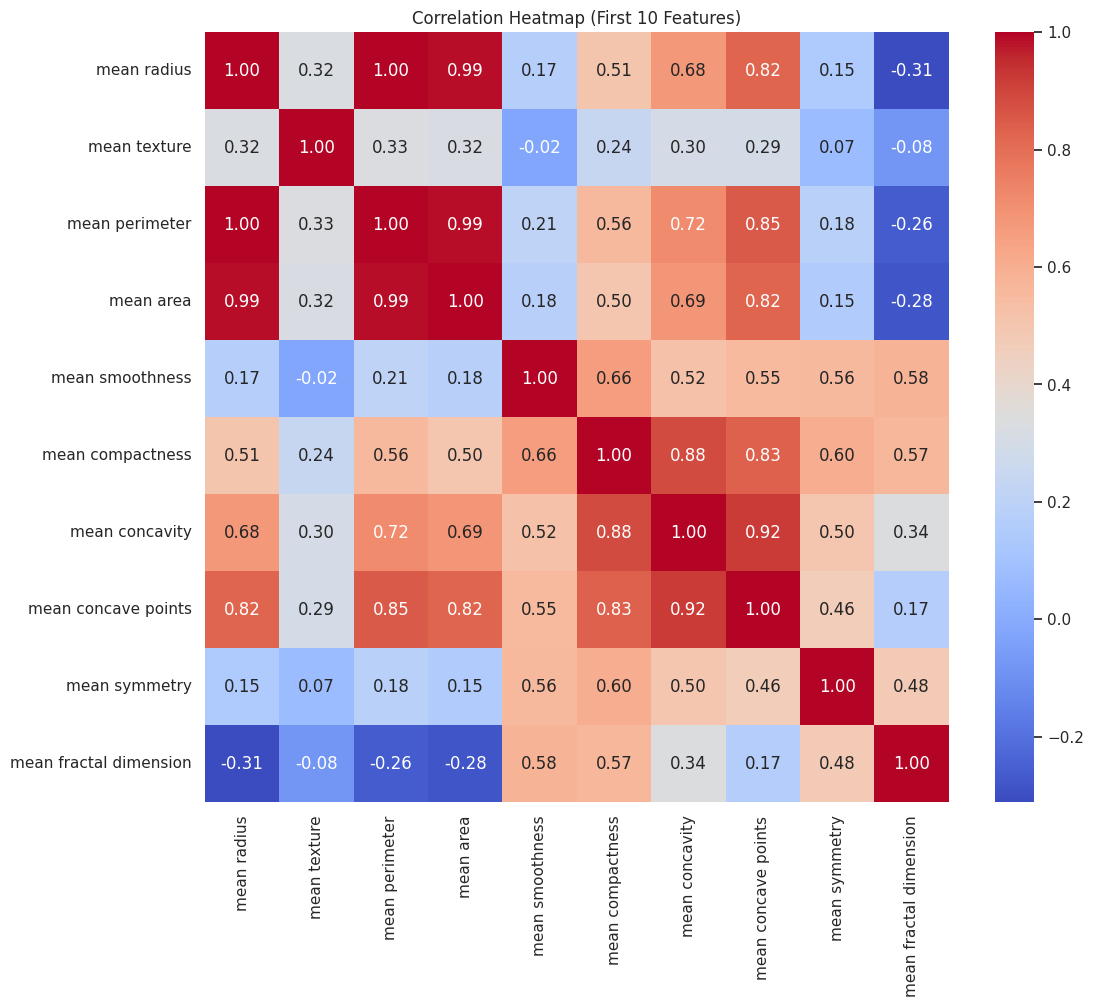

In [ ]:

print("\n1. DATA EXPLORATION")
print("-" * 40)

# Load sample dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# 1.1 Variable Identification
print("\n1.1 Variable Identification")
print("-" * 30)
print("Feature types:")
print(X.dtypes.value_counts())

# 1.2 Univariate Analysis
print("\n1.2 Univariate Analysis")
print("-" * 30)
print("Basic statistics for first 5 features:")
print(X.iloc[:, :5].describe())

# Creating a function to plot histogram and boxplot
def plot_distribution(feature, data=X):
    plt.figure(figsize=(15, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()

# Plot distribution of a sample feature
plot_distribution('mean radius')

# 1.3 Bi-variate Analysis
print("\n1.3 Bi-variate Analysis")
print("-" * 30)

# Correlation plot
plt.figure(figsize=(12, 10))
correlation_matrix = X.iloc[:, :10].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (First 10 Features)')
plt.show()

In [ ]:
# ===============================================================
# 2. Feature Cleaning
# ===============================================================

print("\n2. FEATURE CLEANING")
print("-" * 40)

# 2.1 Missing Values
print("\n2.1 Missing Values")
print("-" * 30)

# Creating a dataframe with missing values
df = X.copy()
# Introducing missing values randomly for demonstration
np.random.seed(42)
for col in df.columns[:5]:  # Add missing values to first 5 columns
    mask = np.random.random(len(df)) < 0.1  # 10% missing values
    df.loc[mask, col] = np.nan

print("Missing values count per column:")
print(df.isnull().sum().head())

print("\nMissing value handling techniques:")

# 2.1.1 Listwise Deletion
print("\n1. Listwise Deletion")
df_listwise = df.dropna()
print(f"Shape after listwise deletion: {df_listwise.shape}")

# 2.1.2 Mean/Median/Mode Imputation
print("\n2. Mean Imputation")
imputer_mean = SimpleImputer(strategy='mean')
df_mean_imputed = pd.DataFrame(
    imputer_mean.fit_transform(df),
    columns=df.columns
)
print(f"Shape after mean imputation: {df_mean_imputed.shape}")

print("\n3. Median Imputation")
imputer_median = SimpleImputer(strategy='median')
df_median_imputed = pd.DataFrame(
    imputer_median.fit_transform(df),
    columns=df.columns
)
print(f"Shape after median imputation: {df_median_imputed.shape}")

# 2.1.3 End of Distribution Imputation (mean + 3*std)
print("\n4. End of Distribution Imputation")
df_end_imputed = df.copy()
for col in df_end_imputed.columns[:5]:
    if df_end_imputed[col].isnull().sum() > 0:
        end_value = df_end_imputed[col].mean() + 3 * df_end_imputed[col].std()
        df_end_imputed[col] = df_end_imputed[col].fillna(end_value)
print(f"Shape after end of distribution imputation: {df_end_imputed.shape}")

# 2.2 Outliers
print("\n2.2 Outliers")
print("-" * 30)

# 2.2.1 Outlier Detection Methods
print("Outlier detection methods:")

# Using Z-score (Mean & Standard Deviation) method
def detect_outliers_zscore(data, threshold=3):
    z_scores = (data - data.mean()) / data.std()
    return data[abs(z_scores) > threshold]

# Using IQR method
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data < lower_bound) | (data > upper_bound)]

sample_feature = 'mean radius'

# Z-score method
outliers_zscore = detect_outliers_zscore(X[sample_feature])
print(f"\n1. Z-score method found {len(outliers_zscore)} outliers in '{sample_feature}'")

# IQR method
outliers_iqr = detect_outliers_iqr(X[sample_feature])
print(f"2. IQR method found {len(outliers_iqr)} outliers in '{sample_feature}'")

# 2.2.2 Handling Outliers
print("\nOutlier handling techniques:")

# Winsorization (capping)
def winsorize(data, limits=(0.05, 0.05)):
    lower_limit = data.quantile(limits[0])
    upper_limit = data.quantile(1 - limits[1])
    return data.clip(lower=lower_limit, upper=upper_limit)

winsorized_data = winsorize(X[sample_feature])
print(f"\n1. Before winsorization: min={X[sample_feature].min():.2f}, max={X[sample_feature].max():.2f}")
print(f"   After winsorization: min={winsorized_data.min():.2f}, max={winsorized_data.max():.2f}")

# 2.3 Rare Values & 2.4 High Cardinality
print("\n2.3 Rare Values & 2.4 High Cardinality")
print("-" * 30)

# Creating a categorical feature with rare values and high cardinality
np.random.seed(42)
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
weights = [0.4, 0.3, 0.1, 0.05, 0.05, 0.02, 0.03, 0.02, 0.02, 0.01]  # Making some values rare
categorical_data = pd.Series(np.random.choice(categories, size=len(X), p=weights))

print("Value counts in categorical variable:")
print(categorical_data.value_counts())

# Handling rare values by grouping
rare_threshold = 0.05  # Consider categories with < 5% occurrence as rare
value_counts = categorical_data.value_counts(normalize=True)
rare_categories = value_counts[value_counts < rare_threshold].index.tolist()

print(f"\nRare categories (< 5% occurrence): {rare_categories}")

categorical_grouped = categorical_data.copy()
categorical_grouped = categorical_grouped.apply(lambda x: 'Other' if x in rare_categories else x)

print("\nValue counts after grouping rare values:")
print(categorical_grouped.value_counts())



2. FEATURE CLEANING
----------------------------------------

2.1 Missing Values
------------------------------
Missing values count per column:
mean radius        70
mean texture       53
mean perimeter     58
mean area          60
mean smoothness    66
dtype: int64

Missing value handling techniques:

1. Listwise Deletion
Shape after listwise deletion: (314, 30)

2. Mean Imputation
Shape after mean imputation: (569, 30)

3. Median Imputation
Shape after median imputation: (569, 30)

4. End of Distribution Imputation
Shape after end of distribution imputation: (569, 30)

2.2 Outliers
------------------------------
Outlier detection methods:

1. Z-score method found 5 outliers in 'mean radius'
2. IQR method found 14 outliers in 'mean radius'

Outlier handling techniques:

1. Before winsorization: min=6.98, max=28.11
   After winsorization: min=9.53, max=20.58

2.3 Rare Values & 2.4 High Cardinality
------------------------------
Value counts in categorical variable:
A    228
B    161



3. FEATURE ENGINEERING
----------------------------------------

3.1 Feature Scaling
------------------------------
Original data: [ 1  2  3  4  5  6  7  8  9 10 50]
Standardized (Z-score): [-0.65 -0.58 -0.5  -0.42 -0.35 -0.27 -0.19 -0.12 -0.04  0.03  3.09]
Min-Max scaled: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 1.  ]
Robust scaled: [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  8.8]


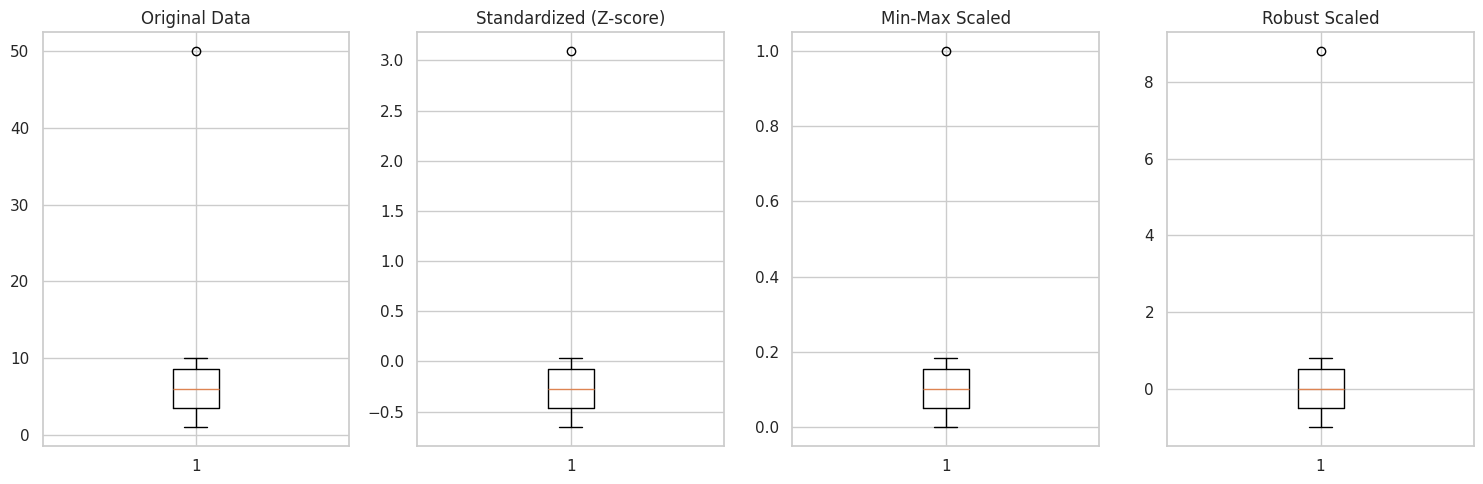


3.2 Discretization
------------------------------
Original feature statistics: min=6.98, max=28.11

1. Equal-width binning (5 bins):
mean radius
(6.96, 11.207]       98
(11.207, 15.433]    314
(15.433, 19.658]    105
(19.658, 23.884]     45
(23.884, 28.11]       7
Name: count, dtype: int64

2. Equal-frequency binning (5 bins):
mean radius
(6.9799999999999995, 11.366]    114
(11.366, 12.726]                114
(12.726, 14.058]                113
(14.058, 17.068]                114
(17.068, 28.11]                 114
Name: count, dtype: int64

3. K-means binning (5 bins):
   Bin 0: 130 samples
   Bin 1: 212 samples
   Bin 2: 122 samples
   Bin 3: 92 samples
   Bin 4: 13 samples


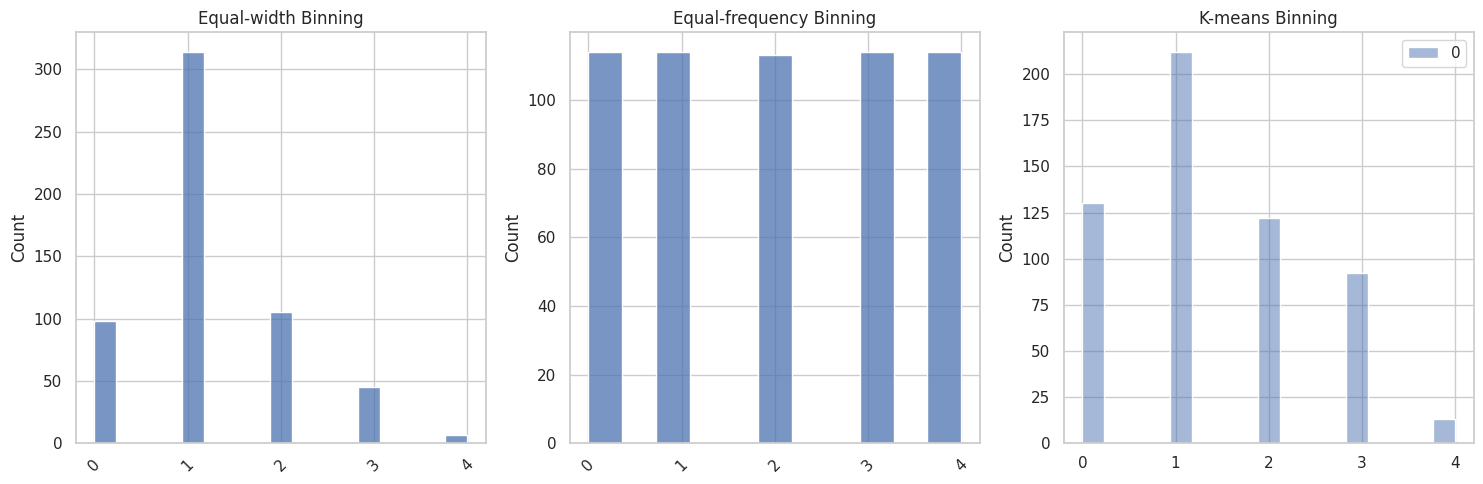


3.3 Feature Encoding
------------------------------
Original categorical data:
   color    size material  target
0    red   small     wood       1
1   blue  medium    metal       0
2  green   large  plastic       1
3    red  medium     wood       1
4   blue   large  plastic       0

1. One-Hot Encoding (with drop='first'):
   color_green  color_red  size_medium  size_small  material_plastic  \
0          0.0        1.0          0.0         1.0               0.0   
1          0.0        0.0          1.0         0.0               0.0   
2          1.0        0.0          0.0         0.0               1.0   
3          0.0        1.0          1.0         0.0               0.0   
4          0.0        0.0          0.0         0.0               1.0   

   material_wood  
0            1.0  
1            0.0  
2            0.0  
3            1.0  
4            0.0  

2. Ordinal Encoding:
   color_ord  size_ord  material_ord
0        2.0       2.0           2.0
1        0.0       1.0         

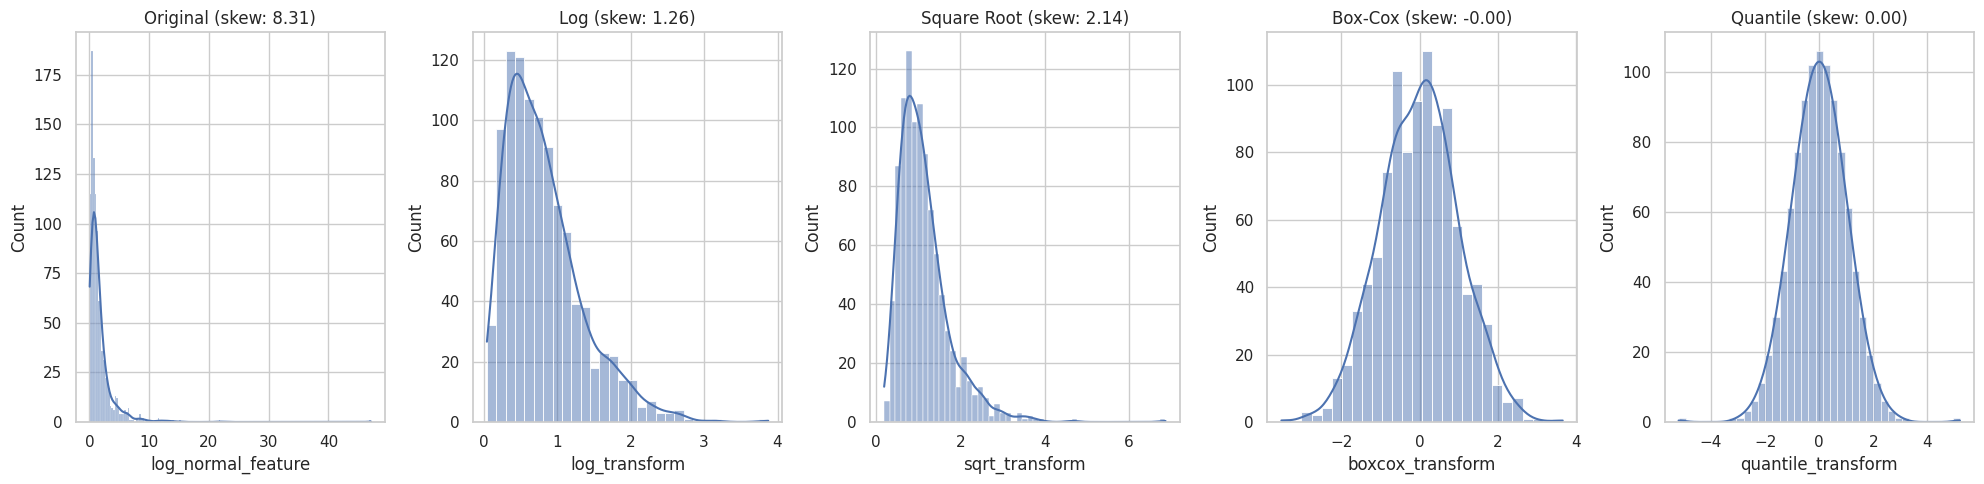


3.5 Feature Generation
------------------------------
Original features:
   age   income  education_years   debt
0   56  91228.0                8  19830
1   69  78984.0               16  17429
2   46  70774.0               19   6893
3   32  32568.0               18  14373
4   60  92592.0               13  47333

1. Missing Data Derived Feature:
    income  income_missing
0  91228.0               0
1  78984.0               0
2  70774.0               0
3  32568.0               0
4  92592.0               0

2. Simple Statistical Derived Feature:
    income  education_years  income_per_edu_year
0  91228.0                8         11403.500000
1  78984.0               16          4936.500000
2  70774.0               19          3724.947368
3  32568.0               18          1809.333333
4  92592.0               13          7122.461538

3. Feature Crossing:
   age   income age_group income_level age_income_group
0   56  91228.0    senior         high      senior_high
1   69  78984.0    sen

In [ ]:

# ===============================================================
# 3. Feature Engineering
# ===============================================================

print("\n3. FEATURE ENGINEERING")
print("-" * 40)

# 3.1 Feature Scaling
print("\n3.1 Feature Scaling")
print("-" * 30)

# Sample with outliers for scaling comparison
sample_data = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50])
print(f"Original data: {sample_data.values}")

# Standardization (Z-score normalization)
scaler_std = StandardScaler()
standardized = scaler_std.fit_transform(sample_data.values.reshape(-1, 1)).flatten()
print(f"Standardized (Z-score): {standardized.round(2)}")

# Min-Max scaling
scaler_minmax = MinMaxScaler()
minmax_scaled = scaler_minmax.fit_transform(sample_data.values.reshape(-1, 1)).flatten()
print(f"Min-Max scaled: {minmax_scaled.round(2)}")

# Robust scaling
scaler_robust = RobustScaler()
robust_scaled = scaler_robust.fit_transform(sample_data.values.reshape(-1, 1)).flatten()
print(f"Robust scaled: {robust_scaled.round(2)}")

# Visualize scaling methods
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.boxplot(sample_data)
plt.title("Original Data")

plt.subplot(1, 4, 2)
plt.boxplot(standardized)
plt.title("Standardized (Z-score)")

plt.subplot(1, 4, 3)
plt.boxplot(minmax_scaled)
plt.title("Min-Max Scaled")

plt.subplot(1, 4, 4)
plt.boxplot(robust_scaled)
plt.title("Robust Scaled")

plt.tight_layout()
plt.show()

# 3.2 Discretization
print("\n3.2 Discretization")
print("-" * 30)

# Sample feature for discretization
feature_to_discretize = X['mean radius']
print(f"Original feature statistics: min={feature_to_discretize.min():.2f}, max={feature_to_discretize.max():.2f}")

# Equal-width binning
n_bins = 5
bin_width = (feature_to_discretize.max() - feature_to_discretize.min()) / n_bins
equal_width_bins = pd.cut(feature_to_discretize, bins=n_bins)
print(f"\n1. Equal-width binning ({n_bins} bins):")
print(equal_width_bins.value_counts().sort_index())

# Equal-frequency binning
equal_freq_bins = pd.qcut(feature_to_discretize, q=n_bins)
print(f"\n2. Equal-frequency binning ({n_bins} bins):")
print(equal_freq_bins.value_counts().sort_index())

# K-means binning
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
kmeans_bins = kbins.fit_transform(feature_to_discretize.values.reshape(-1, 1))
print(f"\n3. K-means binning ({n_bins} bins):")
bins, counts = np.unique(kmeans_bins, return_counts=True)
for bin_idx, count in zip(bins, counts):
    print(f"   Bin {int(bin_idx)}: {count} samples")

# Visualizing binning methods
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Convert the Interval objects to numerical data representing the bin assignments
# before plotting the histogram
sns.histplot(equal_width_bins.cat.codes, kde=False)
plt.title("Equal-width Binning")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
# Convert the Interval objects to numerical data representing the bin assignments
# before plotting the histogram
sns.histplot(equal_freq_bins.cat.codes, kde=False)
plt.title("Equal-frequency Binning")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.histplot(kmeans_bins, kde=False)
plt.title("K-means Binning")

plt.tight_layout()
plt.show()

# 3.3 Feature Encoding
print("\n3.3 Feature Encoding")
print("-" * 30)

# Create a categorical dataset
categorical_df = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'red', 'green'],
    'size': ['small', 'medium', 'large', 'medium', 'large', 'small', 'small'],
    'material': ['wood', 'metal', 'plastic', 'wood', 'plastic', 'metal', 'plastic'],
    'target': [1, 0, 1, 1, 0, 0, 1]
})

print("Original categorical data:")
print(categorical_df.head())

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(categorical_df[['color', 'size', 'material']])
onehot_df = pd.DataFrame(
    onehot_encoded,
    columns=onehot_encoder.get_feature_names_out(['color', 'size', 'material'])
)
print("\n1. One-Hot Encoding (with drop='first'):")
print(onehot_df.head())

# Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
ordinal_encoded = ordinal_encoder.fit_transform(categorical_df[['color', 'size', 'material']])
ordinal_df = pd.DataFrame(
    ordinal_encoded,
    columns=['color_ord', 'size_ord', 'material_ord']
)
print("\n2. Ordinal Encoding:")
print(ordinal_df.head())

# Count/Frequency Encoding
def frequency_encoding(df, col):
    freq_map = df[col].value_counts(normalize=True).to_dict()
    return df[col].map(freq_map)

categorical_df['color_freq'] = frequency_encoding(categorical_df, 'color')
categorical_df['size_freq'] = frequency_encoding(categorical_df, 'size')
categorical_df['material_freq'] = frequency_encoding(categorical_df, 'material')

print("\n3. Frequency Encoding:")
print(categorical_df[['color', 'color_freq', 'size', 'size_freq', 'material', 'material_freq']].head())

# Mean/Target Encoding
def target_encoding(df, col, target='target'):
    target_map = df.groupby(col)[target].mean().to_dict()
    return df[col].map(target_map)

categorical_df['color_target'] = target_encoding(categorical_df, 'color')
categorical_df['size_target'] = target_encoding(categorical_df, 'size')
categorical_df['material_target'] = target_encoding(categorical_df, 'material')

print("\n4. Mean/Target Encoding:")
print(categorical_df[['color', 'color_target', 'size', 'size_target', 'material', 'material_target']].head())

# 3.4 Feature Transformation
print("\n3.4 Feature Transformation")
print("-" * 30)

# Create skewed data for transformation
np.random.seed(42)
log_normal_data = np.exp(np.random.normal(0, 1, 1000))
feature_name = 'log_normal_feature'
skewed_df = pd.DataFrame({feature_name: log_normal_data})

print(f"Skewed data statistics: mean={skewed_df[feature_name].mean():.2f}, skew={skewed_df[feature_name].skew():.2f}")

# Logarithmic transformation
skewed_df['log_transform'] = np.log1p(skewed_df[feature_name])  # log(x+1) to handle zeros

# Square root transformation
skewed_df['sqrt_transform'] = np.sqrt(skewed_df[feature_name])

# Box-Cox transformation
pt = PowerTransformer(method='box-cox')
skewed_df['boxcox_transform'] = pt.fit_transform(skewed_df[[feature_name]])

# Quantile transformation
qt = QuantileTransformer(output_distribution='normal')
skewed_df['quantile_transform'] = qt.fit_transform(skewed_df[[feature_name]])

# Visualizing transformations
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
sns.histplot(skewed_df[feature_name], kde=True)
plt.title(f"Original (skew: {skewed_df[feature_name].skew():.2f})")

plt.subplot(1, 5, 2)
sns.histplot(skewed_df['log_transform'], kde=True)
plt.title(f"Log (skew: {skewed_df['log_transform'].skew():.2f})")

plt.subplot(1, 5, 3)
sns.histplot(skewed_df['sqrt_transform'], kde=True)
plt.title(f"Square Root (skew: {skewed_df['sqrt_transform'].skew():.2f})")

plt.subplot(1, 5, 4)
sns.histplot(skewed_df['boxcox_transform'], kde=True)
plt.title(f"Box-Cox (skew: {skewed_df['boxcox_transform'].skew():.2f})")

plt.subplot(1, 5, 5)
sns.histplot(skewed_df['quantile_transform'], kde=True)
plt.title(f"Quantile (skew: {skewed_df['quantile_transform'].skew():.2f})")

plt.tight_layout()
plt.show()

# 3.5 Feature Generation
print("\n3.5 Feature Generation")
print("-" * 30)

# Create new dataset for feature generation examples
np.random.seed(42)
data_gen = pd.DataFrame({
    'age': np.random.randint(18, 70, 100),
    'income': np.random.randint(30000, 100000, 100),
    'education_years': np.random.randint(8, 22, 100),
    'debt': np.random.randint(0, 50000, 100),
})

# Introduce some missing values
data_gen.loc[np.random.choice(data_gen.index, 10), 'income'] = np.nan

print("Original features:")
print(data_gen.head())

# 3.5.1 Missing Data Derived Feature
data_gen['income_missing'] = data_gen['income'].isna().astype(int)
print("\n1. Missing Data Derived Feature:")
print(data_gen[['income', 'income_missing']].head())

# 3.5.2 Simple Statistical Derived Feature
data_gen['income_per_edu_year'] = data_gen['income'] / data_gen['education_years']
print("\n2. Simple Statistical Derived Feature:")
print(data_gen[['income', 'education_years', 'income_per_edu_year']].head())

# 3.5.3 Feature Crossing - Binning + Crossing
data_gen['age_group'] = pd.cut(data_gen['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])
data_gen['income_level'] = pd.cut(data_gen['income'].fillna(data_gen['income'].median()),
                                 bins=[0, 40000, 70000, 1000000],
                                 labels=['low', 'medium', 'high'])

# Cross features
data_gen['age_income_group'] = data_gen['age_group'].astype(str) + "_" + data_gen['income_level'].astype(str)
print("\n3. Feature Crossing:")
print(data_gen[['age', 'income', 'age_group', 'income_level', 'age_income_group']].head())

# 3.5.4 Ratios and Proportions
data_gen['debt_to_income_ratio'] = data_gen['debt'] / data_gen['income'].fillna(data_gen['income'].median())
print("\n4. Ratios and Proportions:")
print(data_gen[['debt', 'income', 'debt_to_income_ratio']].head())

# 3.5.5 Polynomial Expansion
from sklearn.preprocessing import PolynomialFeatures

features_for_poly = data_gen[['age', 'education_years']].head()
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(features_for_poly)
poly_df = pd.DataFrame(
    poly_features,
    columns=poly.get_feature_names_out(['age', 'education_years'])
)

print("\n5. Polynomial Expansion:")
print(features_for_poly.head())
print("\nAfter polynomial expansion:")
print(poly_df.head())

# 3.5.6 Feature Learning by Trees
print("\n6. Feature Learning by Trees:")
np.random.seed(42)
X_sample = data_gen[['age', 'income', 'education_years', 'debt']].fillna(0)
y_sample = np.random.randint(0, 2, len(X_sample))  # Binary target for demonstration

# Train a Random Forest
rf = RandomForestClassifier(n_estimators=10, max_depth=3)
rf.fit(X_sample, y_sample)

# Extract feature importances
feature_importance = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(feature_importance)



4. FEATURE SELECTION
----------------------------------------
Training data shape: (455, 30)
Testing data shape: (114, 30)

4.1 Filter Method
------------------------------
1. Variance Check:
Feature variance range: Min=0.0000, Max=322252.4539

2. Chi-square Test:
Selected features: ['mean perimeter', 'mean area', 'area error', 'worst perimeter', 'worst area']

3. Mutual Information:
Selected features: ['mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concave points']

4. Univariate ROC-AUC:
Top 5 features:
   worst perimeter: 0.9704
   worst radius: 0.9647
   worst area: 0.9641
   worst concave points: 0.9640
   mean concave points: 0.9626

4.2 Wrapper Method
------------------------------
Forward Selection Example (simplified, using only first 10 features):
Step 1: Added 'mean area' (Score: 0.8769)
Step 2: Added 'mean texture' (Score: 0.8901)
Step 3: Added 'mean perimeter' (Score: 0.8923)

4.3 Embedded Method
------------------------------
1. Lasso Regu

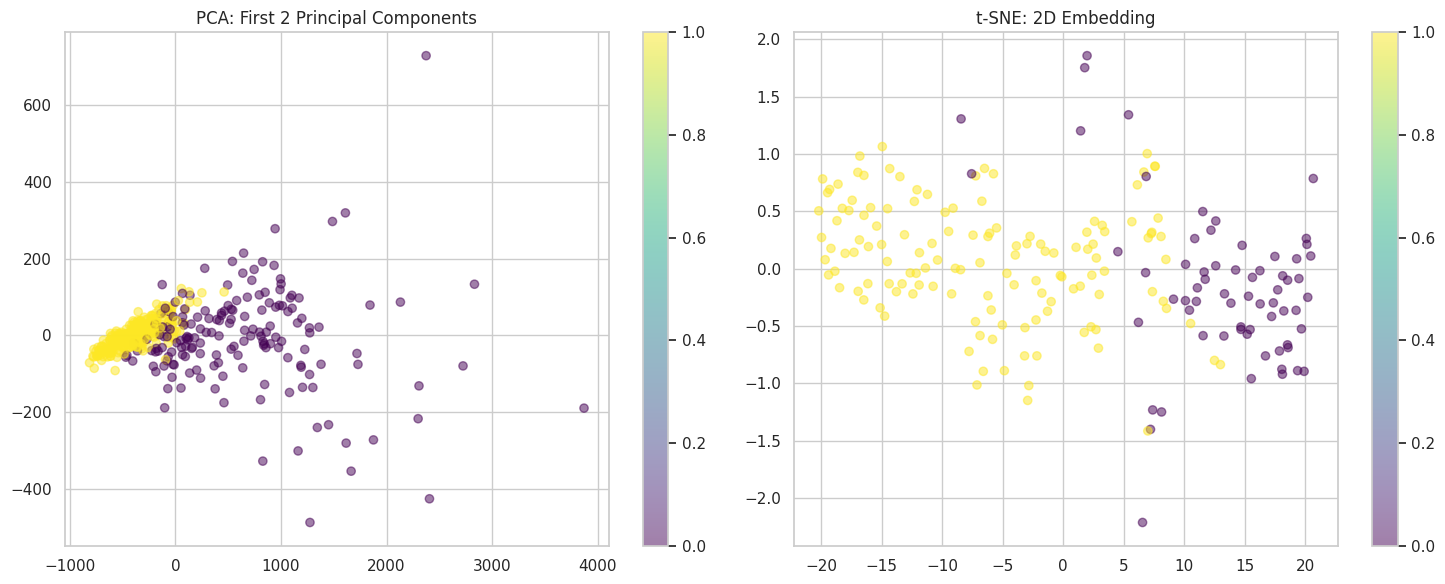

In [ ]:

# ===============================================================
# 4. Feature Selection
# ===============================================================

print("\n4. FEATURE SELECTION")
print("-" * 40)

# Prepare data for feature selection
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 4.1 Filter Method
print("\n4.1 Filter Method")
print("-" * 30)

# Variance Threshold
print("1. Variance Check:")
print(f"Feature variance range: Min={X_train.var().min():.4f}, Max={X_train.var().max():.4f}")

# Chi-square test (for classification)
chi2_selector = SelectKBest(chi2, k=5)
X_train_chi2 = chi2_selector.fit_transform(X_train - X_train.min(), y_train)
selected_features_chi2 = X_train.columns[chi2_selector.get_support()]

print("\n2. Chi-square Test:")
print(f"Selected features: {selected_features_chi2.tolist()}")

# Mutual information
mi_selector = SelectKBest(mutual_info_classif, k=5)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
selected_features_mi = X_train.columns[mi_selector.get_support()]

print("\n3. Mutual Information:")
print(f"Selected features: {selected_features_mi.tolist()}")

# Univariate ROC-AUC
def univariate_roc_auc(X, y):
    feature_scores = {}
    for col in X.columns:
        # Simple model for each feature
        logistic = LogisticRegression(max_iter=1000)
        logistic.fit(X[[col]], y)
        y_pred_proba = logistic.predict_proba(X[[col]])[:, 1]
        score = roc_auc_score(y, y_pred_proba)
        feature_scores[col] = score
    return feature_scores

uni_scores = univariate_roc_auc(X_train, y_train)
top_features_uni = sorted(uni_scores.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n4. Univariate ROC-AUC:")
print("Top 5 features:")
for feature, score in top_features_uni:
    print(f"   {feature}: {score:.4f}")

# 4.2 Wrapper Method
print("\n4.2 Wrapper Method")
print("-" * 30)

# 4.2.1 Forward Selection (simplified example)
def forward_selection_demo(X, y, max_features=3):
    features = []
    remaining = list(X.columns)
    selected = []

    for _ in range(max_features):
        best_score = 0
        best_feature = None

        for feature in remaining:
            current_features = selected + [feature]
            # Train model with current feature set
            model = LogisticRegression(max_iter=1000)
            model.fit(X[current_features], y)
            score = model.score(X[current_features], y)

            if score > best_score:
                best_score = score
                best_feature = feature

        if best_feature:
            features.append((best_feature, best_score))
            selected.append(best_feature)
            remaining.remove(best_feature)

    return features

# Using a subset of features for faster demonstration
X_subset = X_train.iloc[:, :10]
forward_selected = forward_selection_demo(X_subset, y_train)

print("Forward Selection Example (simplified, using only first 10 features):")
for i, (feature, score) in enumerate(forward_selected, 1):
    print(f"Step {i}: Added '{feature}' (Score: {score:.4f})")

# 4.3 Embedded Method
print("\n4.3 Embedded Method")
print("-" * 30)

# 4.3.1 Regularization with Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Get selected features
lasso_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})
lasso_selected = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)

print("1. Lasso Regularization:")
print(f"Number of features selected: {len(lasso_selected)}")
print("Top 5 features by coefficient magnitude:")
print(lasso_selected.head())

# 4.3.2 Random Forest Importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

# Get feature importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n2. Random Forest Importance:")
print("Top 5 features:")
print(rf_importance.head())

# Using SelectFromModel with Random Forest
sfm = SelectFromModel(rf_selector, threshold='median')
sfm.fit(X_train, y_train)
selected_features_rf = X_train.columns[sfm.get_support()]

print(f"\nSelected {len(selected_features_rf)} features using SelectFromModel with Random Forest.")
print(f"First 5 selected features: {selected_features_rf[:5].tolist()}")

# 4.3.3 Gradient Boosted Trees Importance
gb_selector = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_selector.fit(X_train, y_train)

# Get feature importance
gb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_selector.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n3. Gradient Boosting Importance:")
print("Top 5 features:")
print(gb_importance.head())

# 4.4 Feature Shuffling
print("\n4.4 Feature Shuffling")
print("-" * 30)

def feature_shuffling_importance(model, X, y, n_repeats=5):
    # Original score
    model.fit(X, y)
    y_pred = model.predict(X)
    baseline_score = accuracy_score(y, y_pred)

    # Calculate importance for each feature
    importances = {}
    for col in X.columns:
        scores = []
        for _ in range(n_repeats):
            X_shuffled = X.copy()
            X_shuffled[col] = np.random.permutation(X_shuffled[col])
            model.fit(X_shuffled, y)
            y_pred_shuffled = model.predict(X_shuffled)
            shuffled_score = accuracy_score(y, y_pred_shuffled)
            scores.append(baseline_score - shuffled_score)

        importances[col] = np.mean(scores)

    return importances

# Using a smaller subset for demonstration purposes
X_small = X_train.iloc[:100, :5]
y_small = y_train.iloc[:100]

shuffle_importances = feature_shuffling_importance(
    LogisticRegression(max_iter=1000),
    X_small, y_small
)

shuffle_df = pd.DataFrame({
    'Feature': shuffle_importances.keys(),
    'Importance': shuffle_importances.values()
}).sort_values('Importance', ascending=False)

print("Feature Shuffling Importance (simplified example with subset):")
print(shuffle_df)

# 4.5 Hybrid Method
print("\n4.5 Hybrid Method")
print("-" * 30)

# 4.5.1 Recursive Feature Elimination
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe.fit(X_train, y_train)

rfe_selected_features = X_train.columns[rfe.support_]
print("1. Recursive Feature Elimination:")
print(f"Selected features: {rfe_selected_features.tolist()}")

# 4.5.2 Recursive Feature Addition (simplified)
def recursive_feature_addition(X, y, max_features=5):
    """Simplified RFA for demonstration purposes"""
    # Start with an empty feature set
    selected_features = []
    remaining_features = list(X.columns)
    current_score = 0

    for _ in range(max_features):
        best_feature = None
        best_score = current_score

        for feature in remaining_features:
            # Add this feature to current set
            current_features = selected_features + [feature]

            # Train model and evaluate
            model = LogisticRegression(max_iter=1000)
            model.fit(X[current_features], y)
            score = model.score(X[current_features], y)

            # Update if better
            if score > best_score:
                best_score = score
                best_feature = feature

        # If we found a better feature, add it
        if best_feature and best_score > current_score:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            current_score = best_score
        else:
            # No improvement, stop
            break

    return selected_features, current_score

# Using a smaller subset for demonstration
X_subset = X_train.iloc[:, :10]
rfa_features, rfa_score = recursive_feature_addition(X_subset, y_train)

print("\n2. Recursive Feature Addition (simplified):")
print(f"Selected features: {rfa_features}")
print(f"Final score: {rfa_score:.4f}")

# 4.6 Dimensionality Reduction
print("\n4.6 Dimensionality Reduction")
print("-" * 30)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

print("1. PCA:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# t-SNE (for visualization)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train.iloc[:200])  # Using subset for speed

# Visualize dimensionality reduction
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.5, cmap='viridis')
plt.title('PCA: First 2 Principal Components')
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train.iloc[:200], alpha=0.5, cmap='viridis')
plt.title('t-SNE: 2D Embedding')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


In [ ]:
# ===============================================================
# 5. Data Leakage
# ===============================================================

print("\n5. DATA LEAKAGE")
print("-" * 40)

print("Common sources of data leakage:")
print("1. Target leakage: Using information that would not be available at the time of prediction")
print("2. Train-test contamination: When information from test set leaks into training process")
print("3. Improper handling of temporal data: Not respecting time dependencies")
print("4. Inappropriate feature engineering on the entire dataset before splitting")

print("\nBest practices to avoid data leakage:")
print("1. Split your data BEFORE any feature engineering or preprocessing")
print("2. Perform feature selection only on the training set")
print("3. Fit preprocessing models (scalers, encoders, etc.) only on training data")
print("4. Be cautious with time-based data and respect temporal constraints")
print("5. Use proper cross-validation techniques")

# Example of proper preprocessing pipeline to avoid leakage
from sklearn.pipeline import Pipeline

# Create a pipeline that prevents data leakage
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Will be fit only on training data
    ('selector', SelectKBest(mutual_info_classif, k=10)),  # Feature selection only on training data
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the pipeline (preprocessing happens only on training data)
pipeline.fit(X_train, y_train)

# Evaluate on test data (preprocessing transformations learned from training data are applied)
pipeline_score = pipeline.score(X_test, y_test)
print(f"\nPipeline test accuracy (with proper handling to avoid leakage): {pipeline_score:.4f}")

print("\n" + "=" * 40)
print("End of Feature Engineering and Selection Examples")
print("=" * 40)


5. DATA LEAKAGE
----------------------------------------
Common sources of data leakage:
1. Target leakage: Using information that would not be available at the time of prediction
2. Train-test contamination: When information from test set leaks into training process
3. Improper handling of temporal data: Not respecting time dependencies
4. Inappropriate feature engineering on the entire dataset before splitting

Best practices to avoid data leakage:
1. Split your data BEFORE any feature engineering or preprocessing
2. Perform feature selection only on the training set
3. Fit preprocessing models (scalers, encoders, etc.) only on training data
4. Be cautious with time-based data and respect temporal constraints
5. Use proper cross-validation techniques

Pipeline test accuracy (with proper handling to avoid leakage): 0.9825

End of Feature Engineering and Selection Examples
